# 1. Transformer

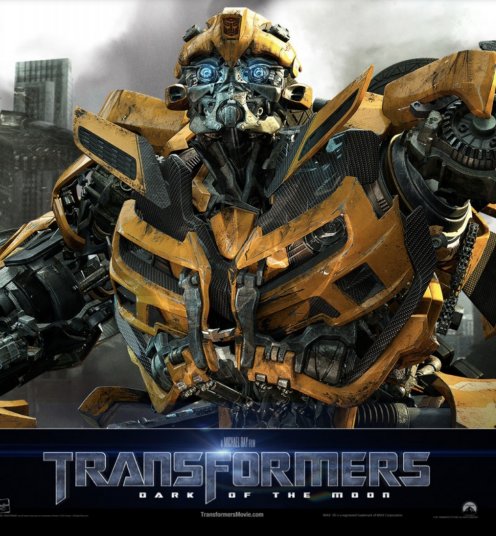

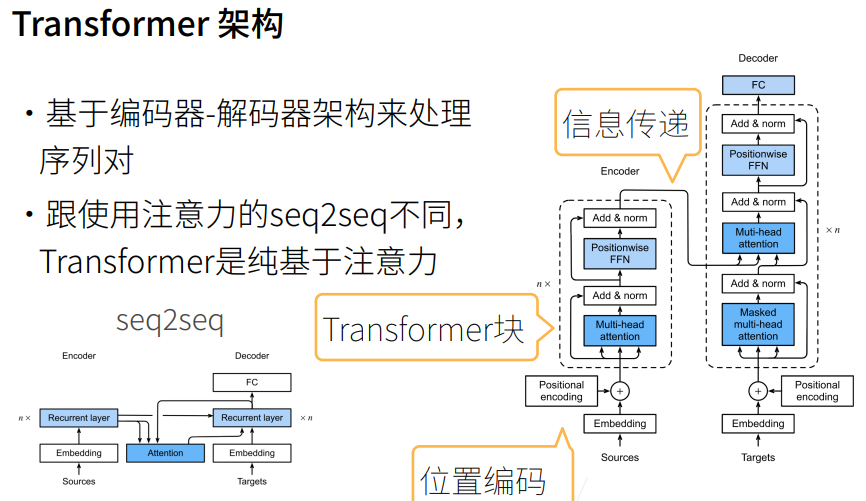

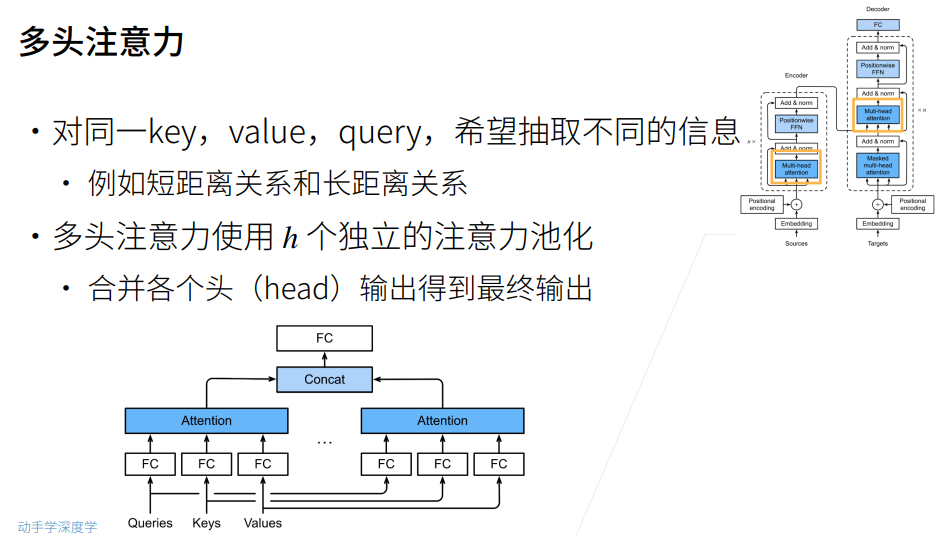

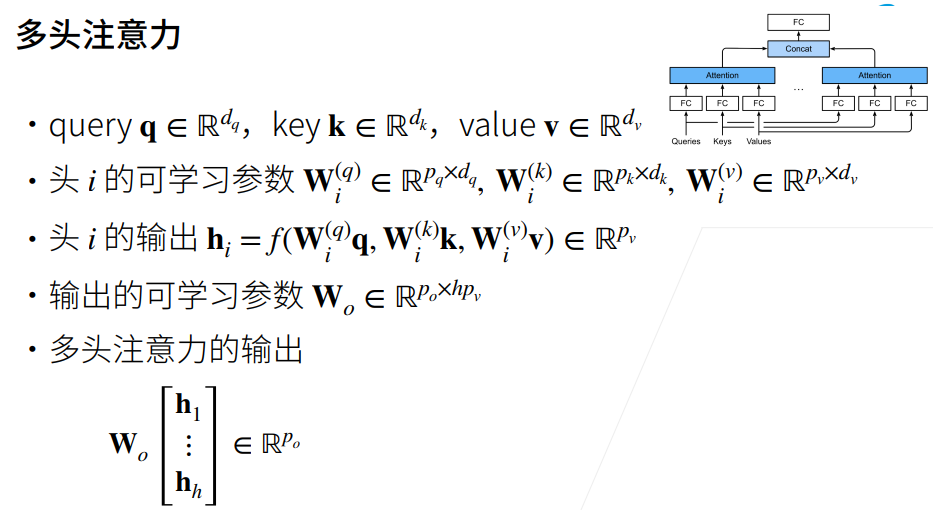

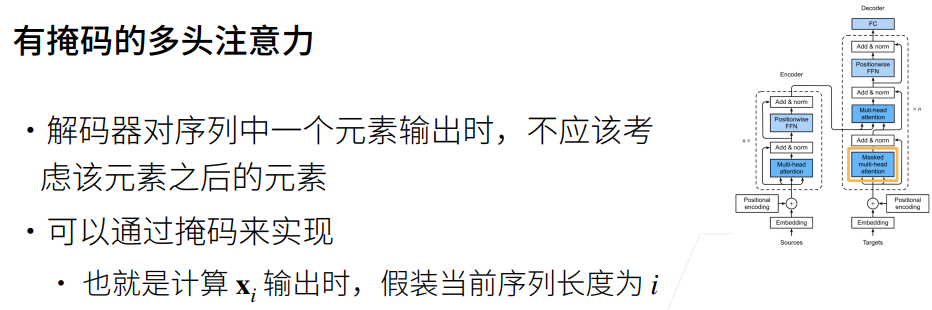

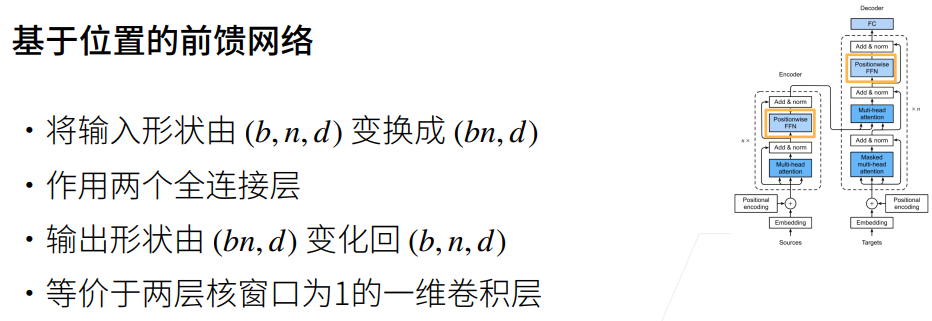

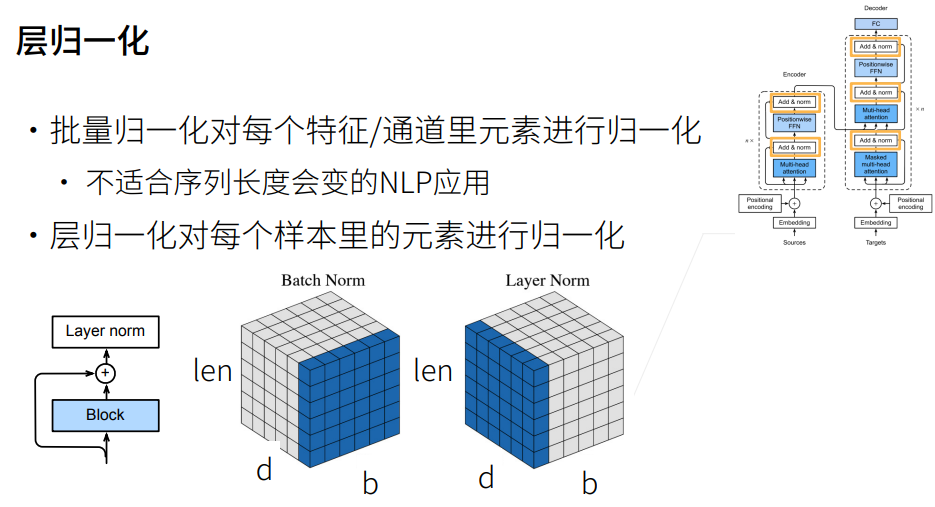

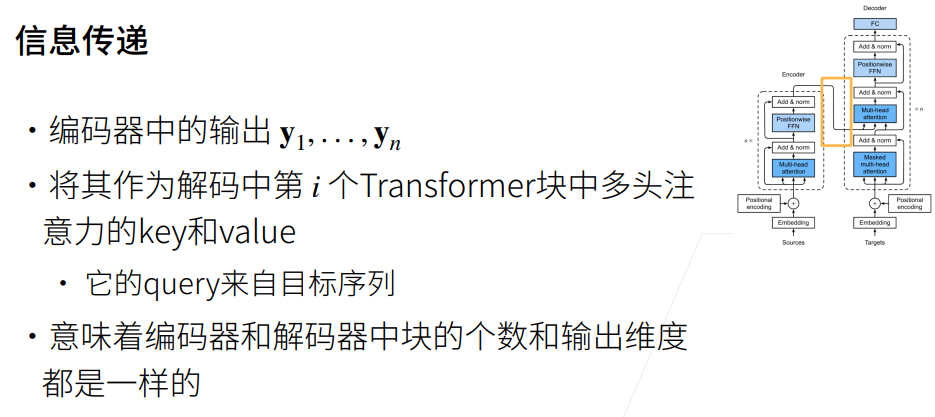

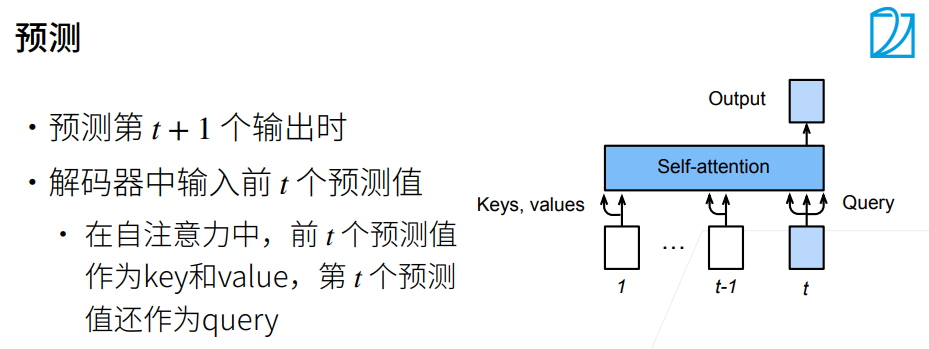

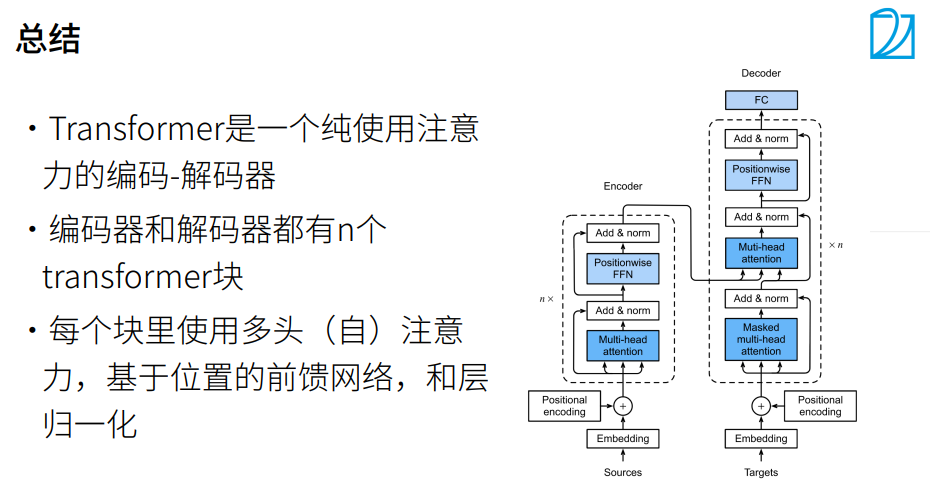

# 2. Transformer

In [1]:
import math
import os
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        # 第一个全连接层，将输入维度从ffn_num_input映射到ffn_num_hiddens
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        # ReLU激活函数，增加非线性特性
        self.relu = nn.ReLU()
        # 第二个全连接层，将输入维度从ffn_num_hiddens映射到ffn_num_outputs
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # 前向传播过程
        # 通过第一个全连接层，将输入X映射到隐藏层
        # 应用ReLU激活函数，增加非线性特性
        # 通过第二个全连接层，将隐藏层映射到输出层
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
# 改变张量的最里层维度的尺寸
# 创建一个PositionWiseFFN实例，输入维度为4，隐藏层维度为4，输出维度为8
ffn = PositionWiseFFN(4, 4, 8)
# 设置模型为评估模式，不进行训练
ffn.eval()
# 创建一个形状为(2, 3, 4)的张量，所有元素都设置为1
# 输入张量通过前馈网络进行前向传播，得到输出张量
# 取第一个样本的输出张量
ffn(torch.ones((2,3,4)))[0]

tensor([[ 0.5166,  0.7577,  0.2357, -0.4697, -0.0154, -0.5645,  0.0913, -0.0949],
        [ 0.5166,  0.7577,  0.2357, -0.4697, -0.0154, -0.5645,  0.0913, -0.0949],
        [ 0.5166,  0.7577,  0.2357, -0.4697, -0.0154, -0.5645,  0.0913, -0.0949]],
       grad_fn=<SelectBackward0>)

In [4]:
# 对比不同维度的层归一化和批量归一化的效果
# 创建一个对最后一个维度进行层归一化的实例
ln = nn.LayerNorm(2)
# 创建一个对最后一个维度进行批量归一化的实例
bn = nn.BatchNorm1d(2)
# 创建一个形状为(2, 2)的张量
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 对张量进行层归一化
# 对张量进行批量归一化
# 打印层归一化和批量归一化的结果
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
# 使用残差连接和层归一化
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        # 定义一个dropout层，用于随机丢弃部分神经元
        self.dropout = nn.Dropout(dropout)
        # 定义一个层归一化层，对输入进行归一化
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        # 前向传播过程
        # 使用残差连接：将dropout(Y)与X相加
        # 应用层归一化：对残差进行归一化
        return self.ln(self.dropout(Y) + X)

In [6]:
# 加法操作后输出张量的形状相同
# 创建一个AddNorm实例，输入的归一化维度为[3, 4]，dropout率为0.5
add_norm = AddNorm([3,4],0.5)
# 设置模型为评估模式，不进行训练
add_norm.eval()
# 创建一个形状为(2, 3, 4)的张量作为X
# 创建一个形状为(2, 3, 4)的张量作为Y
# 输入X和Y通过AddNorm进行前向传播
# 打印输出结果的形状
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

In [7]:
# 实现编码器中的一个层
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # 多头注意力机制
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                               value_size, num_hiddens,
                                               num_heads, dropout, use_bias)   
        # 第一个残差连接和层归一化模块
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 位置前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 第二个残差连接和层归一化模块
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, valid_lens):
        # 前向传播过程
        # 多头注意力机制：计算注意力权重并应用于X
        # 第一个残差连接和层归一化模块：将注意力输出与X相加并进行归一化
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        # 位置前馈网络：对第一个残差连接和层归一化模块的输出进行位置前馈网络操作
        # 第二个残差连接和层归一化模块：将位置前馈网络输出与第一个残差连接和层归一化模块的输出相加并进行归一化
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
# Transformer编码器中的任何层都不会改变其输入的状态
# 创建一个形状为(2, 100, 24)的张量作为输入X
X = torch.ones((2,100,24))
# 创建一个形状为(2,)的张量作为有效长度
valid_lens = torch.tensor([3,2])
# 创建一个EncoderBlock实例
encoder_blk = EncoderBlock(24,24,24,24,[100,24],24,48,8,0.5)
# 设置模型为评估模式，不进行训练
encoder_blk.eval()
# 输入X和有效长度通过EncoderBlock进行前向传播
# 打印输出结果的形状
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [9]:
# Transformer编码器
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                num_heads, num_layers, dropout, use_bias=False, **kwargs): 
        super(TransformerEncoder, self).__init__(**kwargs)
        # 词嵌入层
        self.num_hiddens = num_hiddens
        # 位置编码层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 创建多个编码器块组成的序列
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 创建了一个空的顺序容器self.blks，用于存储多个编码器块
        self.blks = nn.Sequential()
        # 通过循环迭代的方式，逐个添加编码器块到顺序容器self.blks中
        for i in range(num_layers):
            # 使用self.blks.add_module()方法将一个新的编码器块添加到顺序容器中
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
            
    def forward(self, X, valid_lens, *args):
        # 前向传播过程
        # 词嵌入层：对输入进行词嵌入操作
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))   
        # 用于存储每个编码器块中的注意力权重
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            # 编码器块：将词嵌入结果传入编码器块进行处理
            X = blk(X, valid_lens)
            # 将每个编码器块的注意力权重存储到self.attention_weights列表中的对应位置
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
# 创建一个两层的Transformer编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)     
# 将编码器设置为评估模式
encoder.eval()
# 对输入数据进行前向传播，获取输出的形状
encoder(torch.ones((2,100),dtype=torch.long),valid_lens).shape

torch.Size([2, 100, 24])

In [11]:
# Transformer解码器也是由多个相同的层组成
class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        # 第一个多头注意力机制
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout)
        # 第一个残差连接和层归一化模块
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 第二个多头注意力机制
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout)
        # 第二个残差连接和层归一化模块
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 位置前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)   
        # 第三个残差连接和层归一化模块
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        # 从state中提取编码器输出的相关信息
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 检查状态中当前解码器块的键-值对是否为None
        if state[2][self.i] is None:
            key_values = X
        else:
            # 将当前解码器块的键-值对与输入X在维度1上进行拼接
            key_values = torch.cat((state[2][self.i], X), axis=1)
        # 更新状态中当前解码器块的键-值对
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # 生成一个从1到num_steps的张量，用于表示解码器输入的有效长度
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                         device = X.device).repeat(batch_size, 1)   
        else:
            # 在评估模式下，解码器输入的有效长度为None
            dec_valid_lens = None
        # 第一个多头注意力机制的输出
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        # 第一个残差连接和层归一化模块的输出
        Y = self.addnorm1(X, X2)
        # 第二个多头注意力机制的输出
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        # 第二个残差连接和层归一化模块的输出
        Z = self.addnorm2(Y, Y2)
        # 最终输出经过第三个残差连接和层归一化模块处理，返回结果和更新后的状态
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
# 编码器和解码器的特征维度都是num_hiddens
# 创建一个解码器块实例，特征维度为24
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
# 将解码器块设置为评估模式
decoder_blk.eval()
# 创建一个形状为(2, 100, 24)的输入张量X
X = torch.ones((2, 100, 24))
# 使用编码器块对输入X进行编码，得到编码器的输出和有效长度
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
# 输入X和状态state通过解码器块进行前向传播，得到输出张量
# 打印输出张量的形状
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [13]:
# Transform解码器
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        # 初始化参数
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 创建多个解码器块组成的序列
        self.blks = nn.Sequential()
        # 通过循环迭代的方式，逐个添加解码器块到顺序容器self.blks中
        for i in range(num_layers):
            # 使用self.blks.add_module()方法将一个新的解码器块添加到顺序容器中
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 全连接层，将解码器块的输出转换为词汇表大小的输出
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # 初始化解码器状态
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        # 前向传播过程
        # 词嵌入层：对输入进行词嵌入操作
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))  
        # 用于存储每个解码器块中的注意力权重
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)] 
        for i, blk in enumerate(self.blks):
            # 解码器块：将词嵌入结果传入解码器块进行处理
            X, state = blk(X, state)
            # 将每个解码器块的注意力权重存储到self._attention_weights列表中的对应位置
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights   
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        # 全连接层：将解码器块的输出转换为词汇表大小的输出
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        # 返回注意力权重
        return self._attention_weights

In [14]:
def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    # 下载并解压数据集
    data_dir = d2l.download_extract('fra-eng')
    # 打开文件并读取数据
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

In [15]:
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ''
    # 替换特殊字符并转换为小写
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    # 在标点符号前添加空格，以便于分词
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    # 将字符列表拼接为字符串
    return ''.join(out)

In [16]:
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    source, target = [], []
    # 按行遍历文本
    for i, line in enumerate(text.split('\n')):
        # 检查是否达到指定的样本数量
        if num_examples and i > num_examples:
            break
        # 按制表符分割行，将源语言和目标语言分别存储到source和target列表中
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [17]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    # 检查文本序列长度是否超过指定的最大长度
    if len(line) > num_steps:
        # 如果超过最大长度，则截断序列，只保留前面的num_steps个元素
        return line[:num_steps]
    # 如果未超过最大长度，则使用padding_token进行填充，使序列长度达到num_steps
    return line + [padding_token] * (num_steps - len(line))

In [18]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [19]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    # 载入并预处理文本数据
    text = preprocess_nmt(read_data_nmt())
    # 对文本数据进行词元化
    source, target = tokenize_nmt(text, num_examples)
    # 构建源语言和目标语言的词汇表
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    # 将词元化后的文本数据转换为数值数组，并计算有效长度
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # 构建数据集迭代器
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    # 返回数据集迭代器和词汇表
    return data_iter, src_vocab, tgt_vocab

loss 0.029, 4632.7 tokens/sec on cuda:0


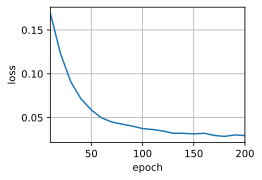

In [20]:
# 训练
# 设置隐藏单元数、层数、丢弃率、批量大小、序列长度
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
# 设置学习率、训练轮数和设备
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
# 设置前馈神经网络的输入维度、隐藏单元数和注意力头数
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
# 设置键、查询和值的维度
key_size, query_size, value_size = 32, 32, 32
# 设置规范化层的形状
norm_shape = [32]
# 加载训练数据集和词汇表
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)   
# 创建Transformer编码器和解码器
encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                            num_hiddens, norm_shape, ffn_num_input,
                            ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                            num_hiddens, norm_shape, ffn_num_input,
                            ffn_num_hiddens, num_heads, num_layers, dropout)
# 创建Encoder-Decoder模型
net = d2l.EncoderDecoder(encoder, decoder)
# 使用序列到序列模型进行训练
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)  

In [21]:
# 将一些英语句子翻译成法语
# 定义一些英语句子和对应的法语翻译
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']   
# 遍历每个英语句子和对应的法语翻译
for eng, fra in zip(engs, fras):
    # 使用训练好的模型进行翻译，并获取解码器注意力权重序列
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    # 打印翻译结果和BLEU评分
    print(f'{eng} => {translation}, ',
         f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va  !,  bleu 0.000
i lost . => j’ai <unk> .,  bleu 0.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [22]:
# 可视化Transformer的注意力权重
# 将编码器的注意力权重拼接起来，并调整形状
enc_attention_weights = torch.cat(net.encoder.attention_weights,0).reshape((
    num_layers, num_heads, -1, num_steps))   
# 打印注意力权重的形状
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

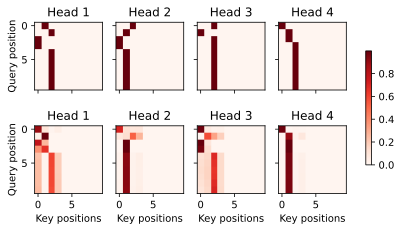

In [23]:
# 使用d2l.show_heatmaps函数展示注意力权重的热图
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                 ylabel = 'Query position',
                 titles = ['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))  

In [24]:
# 为了可视化解码器的自注意力权重和 "编码器-解码器" 的注意力权重，我们需要完成更多的数据操作工作
# 将解码器注意力权重列表转换为二维列表。通过迭代解码器注意力权重序列的步骤、注意力头、块和头部，将注意力权重提取为二维列表      
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
# 将注意力权重的二维列表转换为填充了缺失值的张量
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)   
# 重新调整张量的形状
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
# 提取解码器的自注意力权重和 "编码器-解码器" 的注意力权重
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1,2,3,0,4)   
# 输出解码器的自注意力权重和 "编码器-解码器" 的注意力权重的形状
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

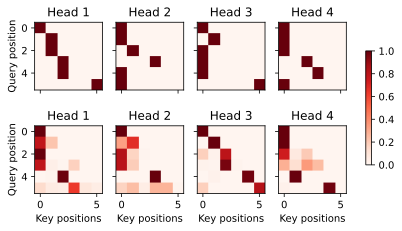

In [25]:
# 可视化解码器的自注意力权重
d2l.show_heatmaps(dec_self_attention_weights[:, :, :, :len(translation.split()) + 1], 
             xlabel = 'Key positions', ylabel = 'Query position',
             titles = ['Head %d' % i for i in range(1,5)], figsize=(7,3.5))

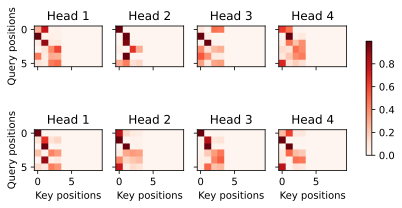

In [26]:
# 输出序列的查询不会与输入序列中填充位置的标记进行注意力计算
# 注意力权重表示输出序列的查询在编码器输出序列的键位置上的注意力分布
d2l.show_heatmaps(dec_inter_attention_weights, xlabel = 'Key positions',
             ylabel = 'Query positions',
             titles = ['Head %d' % i
                      for i in range(1, 5)], figsize=(7, 3.5))   